## *Imports and Installs*

In [18]:
!pip install gensim
!pip install Unidecode
!pip install ml_metrics
!pip install sklearn_evaluation

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Importing Libraries
import pandas as pd
import numpy as np
import multiprocessing
import pickle as pk
import logging  # Setting up the loggings to monitor gensim
import nltk
import seaborn as sb
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('words')

from keras.models import Sequential 
from nltk.corpus import stopwords
from collections import defaultdict
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from gensim import utils
from os import listdir
from os.path import isfile, join
from unidecode import unidecode
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



# import logging, sys
# logging.disable(sys.maxsize)
# logging.getLogger("imported_module").setLevel(logging.WARNING)
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## *Reusable Functions*

In [21]:
# ******** Reusable Functions ******** 

# Serializing dataframes into Objects (for space and fast accesibility)
def serialize(path,data):
  pick = open(path, 'ab')
  pk.dump(data, pick)                     
  pick.close()

# Deserializing the Dataframes from Objects to pre-process.
def deserialize(path):
  pick = open(path, 'rb')     
  df = pk.load(pick)
  pick.close()
  return df

# NAs for individual features.
def count_nas(df):
  lst = pd.DataFrame(columns = ['Column_Name', 'Count_of_missing_values']) 
  cols = df.columns
  for i in cols:
    lst.loc[len(lst.index)] = [i, df[i].isna().sum()]
  return lst

# For Querying Certain products from the dataFrame.
def query_product(dataFrame,product):
  res = dataFrame.query('product_title.str.contains("'+product.lower()+'")', engine='python')
  print(len(res),"Data Points have been retrieved")
  return res

# Retrive columns
def retrieve_column(dataFrame,column):
  return dataFrame[column]
# retrieve_column(df,"review_body")

# ********************************************************************************************************************************************************************************

# Word2Vec Modelling Functions
def basicModel():
  cores = multiprocessing.cpu_count()
  return Word2Vec(min_count=5,
                     window=12,
                     size=300,
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5,
                    workers=cores-1)


def buildVocabulary(model, data):
  model.build_vocab(data, progress_per=10000)

def wordModeltrain(model, processed_reviews):
  model.train(processed_reviews, 
              total_examples=model.corpus_count, 
              epochs=30, 
              report_delay=10000)

# ********************************************************************************************************************************************************************************

# Preprocessing each data-frame
def preprocess_dfs(data):

  # Feature necessary for the project
  features_to_keep = ['product_id', 'review_id', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
  data = data[features_to_keep]

  # res = sr *p1 + hv *p2 +...+rd*pn
  # Dropping missing values
  data = data.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=False)

  # Selecting only those products that are greater then a particular threshold (for now gt 100)
  v = data.product_id.value_counts()
  data = data[data.product_id.isin(v.index[v.gt(100)])]

  data.review_body = data.review_body.str.replace("'", "")
  data.review_body = data.review_body.str.replace("[^A-Za-z0-9]", " ")
  

  # Calculating ratio of helpful and total votes as "ratio_votes"
  data['ratio_votes'] = np.where(data['total_votes']!= 0, np.round(data['helpful_votes']/data['total_votes'],2),0)
  
  data['star_rating'] = data['star_rating'].astype('float')
  
  conditions = [data['star_rating'] < 3,
                data['star_rating'] >= 3 ]
  choices = [0,
             1]
  data['True_value'] = np.select(conditions, choices, default = None)

  return data

global_words = set(nltk.corpus.words.words())
def SentencesToWords(text):
  text = unidecode(text)
  text = str(text)
  text = text.lower()
  text = remove_stopwords(text)
  text = " ".join(w for w in nltk.wordpunct_tokenize(text) 
         if w.lower() in global_words or not w.isalpha())
  text = utils.simple_preprocess(text,min_len=2,max_len=100,deacc=True)
  return text





## *Word2Vec Modeling*

### Loading Datframes 

- From original source

- Tokenizing

- Model Training, saving and loading (hardcoded list)

- Connotation Calculation

- Serializing Dataframes

- Deserializing Dataframes



In [22]:
# ----------------------Loading Datasets from original source.----------------------

mypath = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/Amazon_Reviews"
mypath1 = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Data_Archive"

onlyfiles = []
try:
  for f in listdir(mypath):
    if isfile(join(mypath, f)):
      onlyfiles.append(mypath + '/' + f)
except:
  for f in listdir(mypath1):
    if isfile(join(mypath1, f)):
      onlyfiles.append(mypath1 + '/' + f)

# Fetching all the datasets into dataframes.
df = [pd.DataFrame()] * len(onlyfiles)
dict_df = {} # Stores Product Category with respective dfs
k = 0
for i in onlyfiles:
  df[k] = pd.read_csv(i, sep='\t', error_bad_lines=False, skip_blank_lines=True)
  dict_df[df[k].product_category[0]] = df[k]
  k = k + 1
dict_df.keys()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 10437: expected 15 fields, saw 22\nSkipping line 10443: expected 15 fields, saw 22\nSkipping line 19872: expected 15 fields, saw 22\nSkipping line 20055: expected 15 fields, saw 22\nSkipping line 20107: expected 15 fields, saw 22\nSkipping line 20167: expected 15 fields, saw 22\nSkipping line 53858: expected 15 fields, saw 22\n'
b'Skipping line 72173: expected 15 fields, saw 22\nSkipping line 84308: expected 15 fields, saw 22\nSkipping line 92156: expected 15 fields, saw 22\nSkipping line 97791: expected 15 fields, saw 22\nSkipping line 106812: expected 15 fields, saw 22\n'
b'Skipping line 138899: expected 15 fields, saw 22\nSkipping line 145840: expected 15 fields, saw 22\nSkipping line 192385: expected 15 fields, saw 22\nSkipping line 

dict_keys(['Jewelry', 'Watches'])

In [23]:
# Preprocessing Dataframes and Tokenizing the Reviews

def tokenizingDf(dtf):
  
  dtf = preprocess_dfs(dtf)
  dtf['tokenized'] = dtf.review_body.apply(SentencesToWords)
  return dtf

for i in range(len(df)):
  df[i] = tokenizingDf(df[i])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: FutureWarning: The default value of regex will change from True to False in a future version.


In [24]:
#-----------------------------------------# The Word2Vec Model [Model Training]------------------------------------------------

# Need only execute once the below enclosed snippet to train word models
#-----------------------------------------------------------------------------------------------------------------------------------------------

def modelgen(df):
  wmodel = basicModel()
  buildVocabulary(wmodel,df['tokenized'])
  wordModeltrain(wmodel,df['tokenized'])
  wordTovec = wmodel.wv
  kmodel = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=wordTovec.vectors)

  path_word = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/word2vec_" + str(df.product_category.iloc[0]) +  ".model"
  path_kmeans = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/kmeans_" + str(df.product_category.iloc[0]) +  ".pkl"
  
  path1_word = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/word2vec_" + str(df.product_category.iloc[0]) +  ".model"
  path1_kmeans = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/kmeans_" + str(df.product_category.iloc[0]) +  ".pkl"

  try:
    wmodel.save(path_word)
    serialize(path_kmeans,kmodel)
  except:
    wmodel.save(path1_word)
    serialize(path1_kmeans,kmodel)

#Creating models trained on words
for i in range(len(df)):
  modelgen(df[i])

#-----------------------------------------------------------------------------------------------------------------------------------------------


INFO - 22:03:16: collecting all words and their counts
INFO - 22:03:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:03:16: PROGRESS: at sentence #10000, processed 67102 words, keeping 3967 word types
INFO - 22:03:16: PROGRESS: at sentence #20000, processed 132821 words, keeping 5180 word types
INFO - 22:03:16: PROGRESS: at sentence #30000, processed 196688 words, keeping 5944 word types
INFO - 22:03:16: PROGRESS: at sentence #40000, processed 258716 words, keeping 6587 word types
INFO - 22:03:16: PROGRESS: at sentence #50000, processed 325411 words, keeping 7192 word types
INFO - 22:03:16: PROGRESS: at sentence #60000, processed 389130 words, keeping 7632 word types
INFO - 22:03:16: PROGRESS: at sentence #70000, processed 453492 words, keeping 8002 word types
INFO - 22:03:16: PROGRESS: at sentence #80000, processed 517692 words, keeping 8420 word types
INFO - 22:03:16: PROGRESS: at sentence #90000, processed 583393 words, keeping 8790 word types
INFO - 2

In [25]:
# Loading the word2vec models and knn models

lst = ['Jewelry', 'Watches']
# lst = [str(df[i].product_category.iloc[0]) for i in range(len(df))]

wmodels = []
kmeans = []
for i in range(len(lst)):

  path_word = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/word2vec_" + str(df[i].product_category.iloc[0]) +  ".model"
  path_kmeans = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/kmeans_" + str(df[i].product_category.iloc[0]) +  ".pkl"
  
  path1_word = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/word2vec_" + str(df[i].product_category.iloc[0]) +  ".model"
  path1_kmeans = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/kmeans_" + str(df[i].product_category.iloc[0]) +  ".pkl"

  try:
    wmodel = Word2Vec.load(path_word)
    kmean = deserialize(path_kmeans)
    wmodels.append(wmodel)
    kmeans.append(kmean)
  except:
    wmodel = Word2Vec.load(path1_word)
    kmean = deserialize(path1_kmeans)
    wmodels.append(wmodel)
    kmeans.append(kmean)



INFO - 22:13:01: loading Word2Vec object from /content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/word2vec_Jewelry.model
INFO - 22:13:01: loading wv recursively from /content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/word2vec_Jewelry.model.wv.* with mmap=None
INFO - 22:13:01: setting ignored attribute vectors_norm to None
INFO - 22:13:01: loading vocabulary recursively from /content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/word2vec_Jewelry.model.vocabulary.* with mmap=None
INFO - 22:13:01: loading trainables recursively from /content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/word2vec_Jewelry.model.trainables.* with mmap=None
INFO - 22:13:01: setting ignored attribute cum_table to None
INFO - 22:13:01: loaded /content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/word2vec_Jewelry.model
INFO - 22:13:01: loading Word2Vec

In [26]:
# Connotation Calculation (negative or positive)

# !---Creating a dictionary of words (indicating each word belonging to a positive class [1] or negative class [-1])---!

def class_determination(model, pos_cluster, neg_cluster, cnt):

  # Getting the similarity metric (in tuple form - word & similarity) from both the cluster centers to each word
  pos = model.wv.similar_by_vector(pos_cluster, topn=cnt, restrict_vocab=None)
  neg = model.wv.similar_by_vector(neg_cluster, topn=cnt, restrict_vocab=None)
  # print('passed')
  # Empty list of words and their similarities to both clusters (to append words & similarities later on)
  p_words = []
  n_words = []
  p_similarities = []
  n_similarities = []
  p_distances = []
  n_distances = []

  for i in range(cnt):
    p_words.append(pos[i][0])
    p_similarities.append(pos[i][1])
    p_distances.append((1-pos[i][1]))

    n_words.append(neg[i][0])
    n_similarities.append(neg[i][1])
    n_distances.append((1-neg[i][1]))

  df_pos = pd.DataFrame({'word': p_words,
                     'S_pos' : p_similarities,
                     'D_pos' : p_distances
                       })
  df_neg = pd.DataFrame({'word':n_words,
                       'S_neg': n_similarities,
                       'D_neg' : n_distances
                       })
  df_pos = df_pos.sort_values(by=['word'])
  df_neg = df_neg.sort_values(by=['word'])

  # merged from list of words and their similarity clusters.
  result = pd.merge(df_pos, df_neg, on='word', how='outer')

  # Determining the class of a word(positive or negative) based on distance calculated from similarities
  conditions = [result['D_pos'] < result['D_neg'],
                result['D_pos'] > result['D_neg']]
  choices = ['Positive',
             'Negative']

  result['class'] = np.select(conditions, choices, default = None)

  conn_dictionary = {}
  for i in range(len(result)):
    if result.loc[i,'class'] == 'Positive':
      conn_dictionary[result.loc[i,'word']] = 1
    else:
      conn_dictionary[result.loc[i,'word']] = -1
    
  return result, conn_dictionary



In [27]:
# Score Calculation
def score_calculation_df(df, dct):
  def score(lst):
    # print("list : ",lst)
    total = 0
    for i in lst:
      if i in dct:
        # print("dict value : ",i)
        total = total + dct.get(i)
      else:
        total = total + 0
    return total
  df['score'] = df['tokenized'].apply(score)
  # conditions = [df['score'] < 0,
  #               df['score'] >= 0 ]
  # choices = [0,
  #            1]
  # df['predicted_value'] = np.select(conditions, choices, default = None)
  # df['star_rating'] = df['star_rating'].astype('float')
  
  # conditions = [df['star_rating'] < 3,
  #               df['star_rating'] >= 3 ]
  # choices = [0,
  #            1]
  # df['True_value'] = np.select(conditions, choices, default = None)

  return df

In [28]:
# Call for Connotation calculation for all dataframes
class_fixed = []
dicts = []
for i in range(len(df)):
  result, dct = class_determination(wmodels[i], kmeans[i].cluster_centers_[0], kmeans[i].cluster_centers_[1], len(wmodels[i].wv.vocab))
  class_fixed.append(result)
  dicts.append(dct)
  
# Call for Score Calculation of all Dataframes
for i in range(len(df)):
  df[i] = score_calculation_df(df[i],dicts[i])
  

INFO - 22:13:02: precomputing L2-norms of word weight vectors
INFO - 22:13:02: precomputing L2-norms of word weight vectors


In [29]:
# Serializing the dataframes
lst = ['Jewelry', 'Watches']

for i in range(len(lst)):
  print(i)
  path_df = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/df_" + lst[i] +  ".pkl"
  path1_df = '/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/df_' + lst[i] +  '.pkl'
  
  try:
    serialize(path_df, df[i])

  except:
    serialize(path1_df, df[i])


0
try 0
success
1
try 1
success


In [30]:
# Deserializing (Loading) the Dataframes

lst = ['Jewelry', 'Watches']
# lst = [str(df[i].product_category.iloc[0]) for i in range(len(df))]
df = []
for i in range(len(lst)):
  path_df = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/versions/version8/df_" + lst[i] +  ".pkl"
  path1_df = '/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/df_' + lst[i] +  '.pkl'
  try:
    df.append(deserialize(path_df))
  except:
    df.append(deserialize(path1_df))



## Evaluation

In [31]:
# Prior step to determine
for i in range(len(df)):
  tmp = df[i]
  conditions = [tmp['score'] < 0,
                tmp['score'] >= 0 ]
  choices = [0,
             1]
  tmp['predicted_value'] = np.select(conditions, choices, default = None)

  tmp['star_rating'] = tmp['star_rating'].astype('float')
  conditions1 = [tmp['star_rating'] < 3,
                tmp['star_rating'] >= 3 ]
  choices1 = [0,
             1]
  tmp['True_value'] = np.select(conditions1, choices1, default = None)

  df[i] = tmp

#Accuracy, F1-score, Precision and Recall

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from ml_metrics import mapk


data frame  0



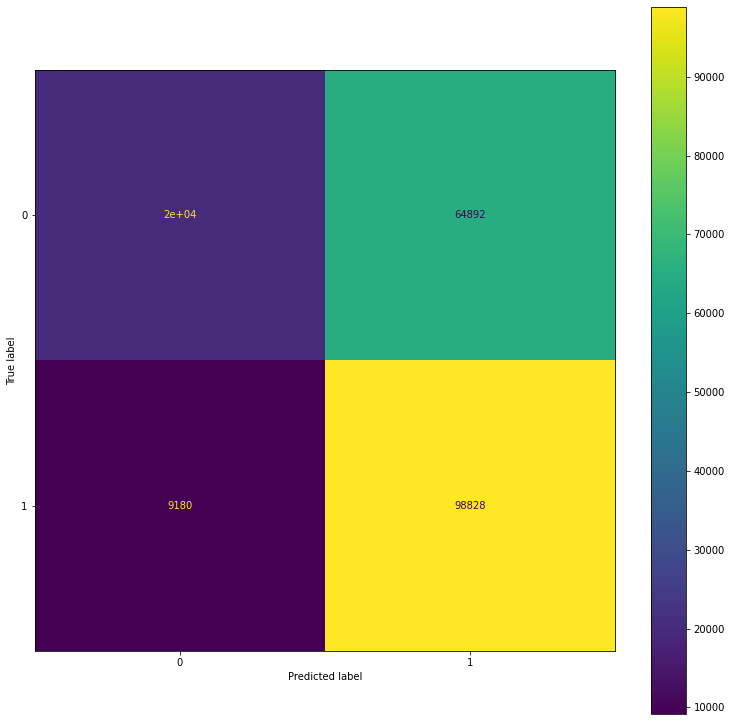

data frame  1



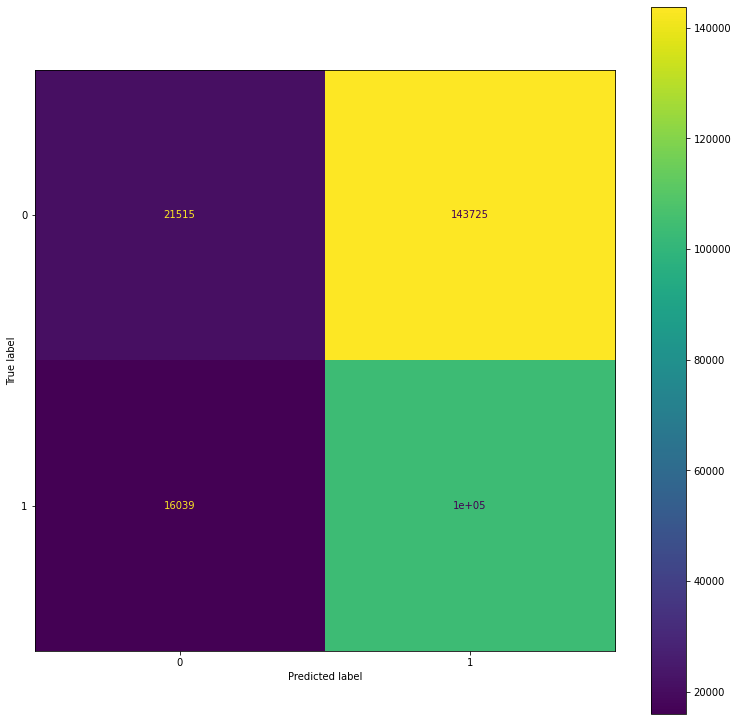

In [32]:
#Confusion Matrix

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print()
  
  cm = confusion_matrix(df[i]['predicted_value'], df[i]['True_value'], labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
  disp.plot()
  plt.show()

In [33]:
#Accuracy

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 

  print("Accuracy:",accuracy_score(df[i]['predicted_value'], df[i]['True_value']))
  print()
  cm = confusion_matrix(df[i]['predicted_value'], df[i]['True_value'], labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])


data frame  0
Accuracy: 0.6165509672676823

data frame  1
Accuracy: 0.4395700765415296



In [34]:
# Precision

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("Precision Score for Positive class : ",precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  # print("Precision Score for Negative class : ",precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  

data frame  0
Precision Score for Positive class :  0.9150062958299385

data frame  1
Precision Score for Positive class :  0.8661565165145118



In [35]:
# Recall

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("Recall Score for Positive class : ",recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("Recall Score for Negative class : ",recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  

data frame  0
Recall Score for Positive class :  0.6036403615929636
Recall Score for Negative class :  0.6883169795946084

data frame  1
Recall Score for Positive class :  0.41933985132514545
Recall Score for Negative class :  0.5729083453160781



In [36]:
# F1 Score

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("F1 Score for Positive class : ",f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("F1 Score for Negative class : ",f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  
  

data frame  0
F1 Score for Positive class :  0.727403874462698
F1 Score for Negative class :  0.3537489748556073

data frame  1
F1 Score for Positive class :  0.5650952487246634
F1 Score for Negative class :  0.21218576486483823



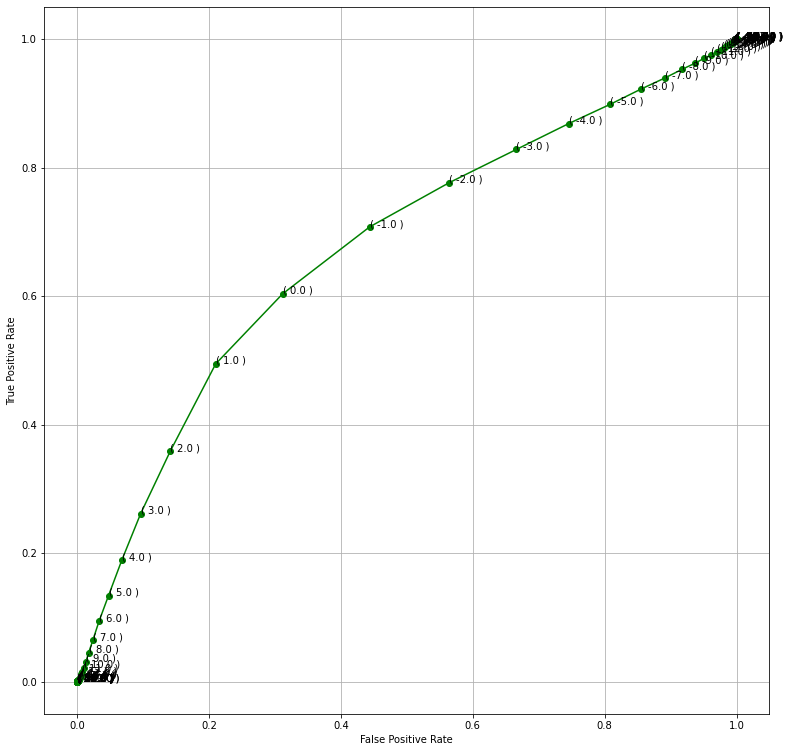

In [37]:
#ROC AUC
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (13,13)

fpr, tpr, threshold = metrics.roc_curve(df[0]['True_value'].astype('int') , df[0]['score'].astype('float'), pos_label=1)

fig = plt.figure()
ax = fig.add_subplot(111)
i = 0
ax.plot(fpr,tpr,'go-')
for xy in zip(fpr, tpr):
  ax.annotate('( %s )' % threshold[i], xy=xy, textcoords='data')
  i = i + 1
ax.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Evaluation 2 (post sigmoid)

In [38]:
#--Sigmoid
def sigmoid(z):
  return 1/(1+ np.exp(-z))


for i in range(len(df)):

  tmp = df[i]
  tmp['score'] = round(tmp.score.apply(sigmoid),2)
  conditions = [tmp['score'] < 0.5,
                tmp['score'] >= 0.5 ]
  choices = [0,
             1]
  tmp['predicted_value'] = np.select(conditions, choices, default = None)

  tmp['star_rating'] = tmp['star_rating'].astype('float')
  conditions1 = [tmp['star_rating'] < 3,
                tmp['star_rating'] >= 3 ]
  choices1 = [0,
             1]
  tmp['True_value'] = np.select(conditions1, choices1, default = None)

  df[i] = tmp



data frame  0



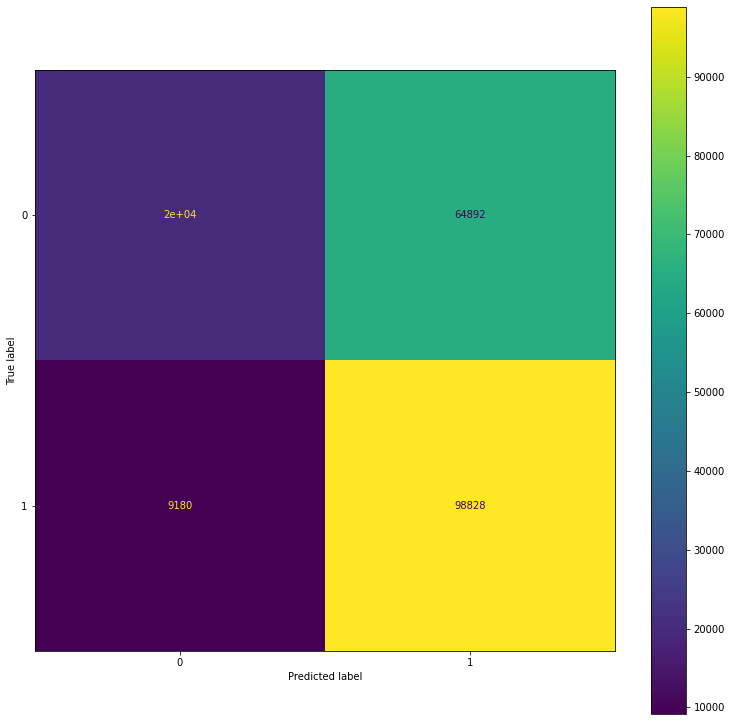

data frame  1



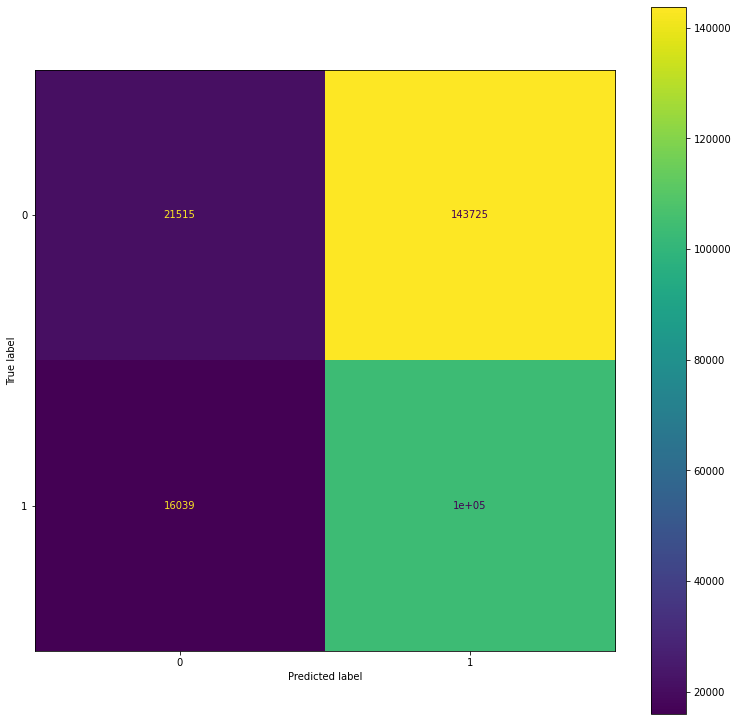

In [39]:
#Confusion Matrix

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print()
  
  cm = confusion_matrix(df[i]['predicted_value'], df[i]['True_value'], labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
  disp.plot()
  plt.show()

In [40]:
#Accuracy

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 

  print("Accuracy:",accuracy_score(df[i]['predicted_value'], df[i]['True_value']))
  print()
  cm = confusion_matrix(df[i]['predicted_value'], df[i]['True_value'], labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])


data frame  0
Accuracy: 0.6165509672676823

data frame  1
Accuracy: 0.4395700765415296



In [41]:
# Precision

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("Precision Score for Positive class : ",precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("Precision Score for Negative class : ",precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  

data frame  0
Precision Score for Positive class :  0.9150062958299385
Precision Score for Negative class :  0.2380437973345858

data frame  1
Precision Score for Positive class :  0.8661565165145118
Precision Score for Negative class :  0.13020455095618494



In [42]:
# Recall

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("Recall Score for Positive class : ",recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("Recall Score for Negative class : ",recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()

data frame  0
Recall Score for Positive class :  0.6036403615929636
Recall Score for Negative class :  0.6883169795946084

data frame  1
Recall Score for Positive class :  0.41933985132514545
Recall Score for Negative class :  0.5729083453160781



In [43]:
# F1 Score

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("F1 Score for Positive class : ",f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("F1 Score for Negative class : ",f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  
  

data frame  0
F1 Score for Positive class :  0.727403874462698
F1 Score for Negative class :  0.3537489748556073

data frame  1
F1 Score for Positive class :  0.5650952487246634
F1 Score for Negative class :  0.21218576486483823



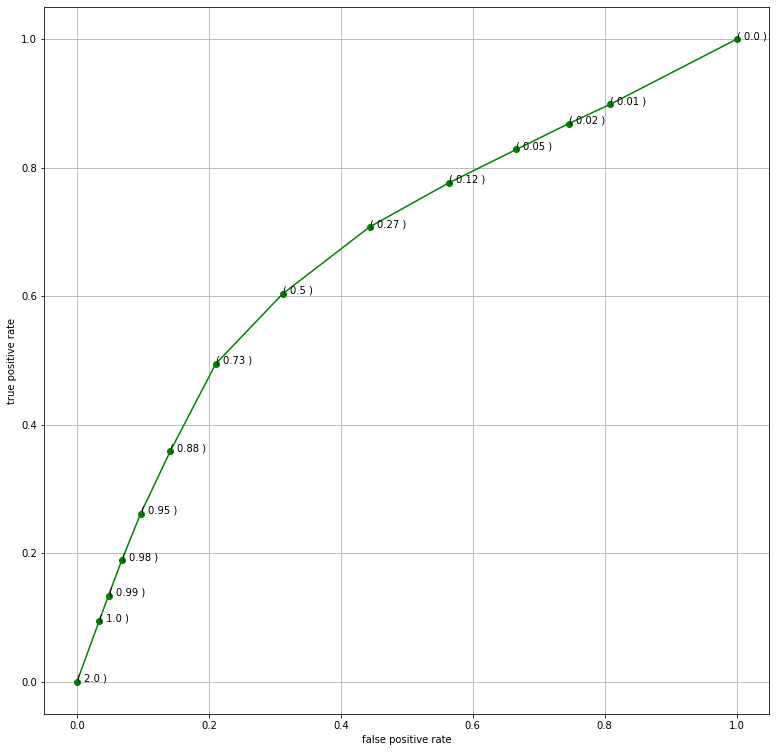

In [44]:
#ROC AUC
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (13,13)
# plt.style.use('dark_background')

fpr, tpr, threshold = metrics.roc_curve(df[0]['True_value'].astype('int') , df[0]['score'].astype('float'), pos_label=1)

fig = plt.figure()
ax = fig.add_subplot(111)
i = 0
ax.plot(fpr,tpr,'go-')

for xy in zip(fpr, tpr):
  ax.annotate('( %s )' % threshold[i], xy=xy, textcoords='data')
  i = i + 1
ax.grid()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

## Track of Hyperparameter Tuning

In [45]:
def true_predicted(tmp, interval, t, zero_mid, i, w, n):

  conditions = [tmp['score'] < interval, tmp['score'] >= interval ]
  choices = [0, 1]
  tmp['predicted_value'] = np.select(conditions, choices, default = None)
  tmp['star_rating'] = tmp['star_rating'].astype('float')
  
  conditions = [tmp['star_rating'] < t, tmp['star_rating'] >= t ]
  choices = [0, 1]
  tmp['True_value'] = np.select(conditions, choices, default = None)

  df[i] = tmp

  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int')

  acc = round(accuracy_score(df[i]['predicted_value'], df[i]['True_value']), 3)
  f1_pos = round(f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1), 3)
  f1_neg = round(f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0), 3)
  pre_pos = round(precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1), 3)
  pre_neg = round(precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0), 3)
  rec_pos = round(recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1), 3)
  rec_neg = round(recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0), 3)

  dt = 'dataset_' + str(i)
  track_record(dt, w, n, zero_mid, t, acc, f1_pos, f1_neg, pre_pos, pre_neg, rec_pos, rec_neg)



In [46]:
def empty_track_record_file():
  path = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/Track/records.csv"
  row = {'dataset' : [], 'neurons' : [], 'window_size' : [], 'cat':[], 'threshold' : [], 'accuracy' : [], 'f1_score_pos' : [], 'f1_score_neg' : [], 'precision_pos' : [], 'precision_neg' : [], 'recall_pos' : [], 'recall_neg' : []} 
  row = pd.DataFrame(row)
  row.to_csv(path)


def track_record(dataset, neuron_size, window_size, cat, threshold, accuracy, f1_score_pos, f1_score_neg, precision_pos, precision_neg, recall_pos, recall_neg):
  path = "/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/Track/records.csv"
  read_df = pd.read_csv(path,index_col=0)
  row = {'dataset' : [dataset], 'neurons' : [neuron_size], 'window_size' : [window_size], 'cat': [cat], 'threshold' : [threshold], 'accuracy' : [accuracy], 'f1_score_pos' : [f1_score_pos], 'f1_score_neg' : [f1_score_neg], 'precision_pos' : [precision_pos], 'precision_neg' : [precision_neg], 'recall_pos' : [recall_pos], 'recall_neg' : [recall_neg]}  
  row = pd.DataFrame(row)
  read_df = read_df.append(row, ignore_index=True)
  read_df.to_csv(path)


In [47]:
# for i in range(len(df)):
#   intervals = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4, 4.5, 5.0]
#   for j in intervals:
#     point = (max(df[0]['score']) + min(df[0]['score']))/2
#     true_predicted(df[i], interval = 0, t = j, zero_mid = 'zero', i = i , w = 17, n = 300)
#     true_predicted(df[i], interval = point, t = j , zero_mid = 'mid', i = i, w = 17, n = 300)


In [48]:
import warnings
warnings.filterwarnings("ignore")
sb.set_theme(style="ticks", palette="bright")
rec = pd.read_csv("/content/drive/MyDrive/Personal Projects/Sentimental Recommendation/Track/records.csv",index_col=0)


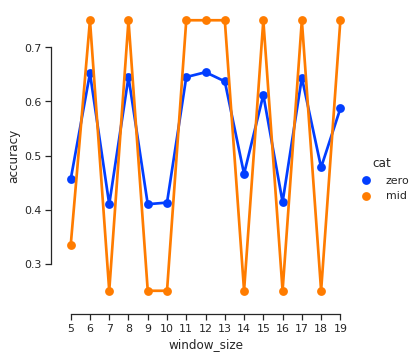

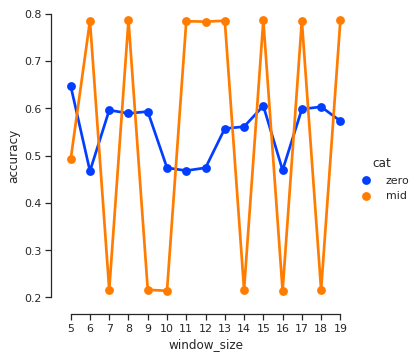

In [49]:
# Window size and its effect on accuracy
rec4 = rec[['dataset','window_size','cat','threshold','accuracy']]
rec4 = rec4[rec4['threshold'] == 4.0]
rec4 = rec4.groupby(['dataset'])


for key, item in rec4:
  tmp = rec4.get_group(key)
  # f, ax = plt.subplots()
  sb.catplot(x='window_size', y='accuracy', hue='cat', data=tmp, kind='point')
  sb.despine(offset=10, trim=True)
  # plt.title(str(key))

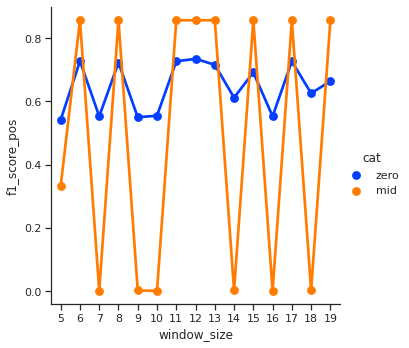

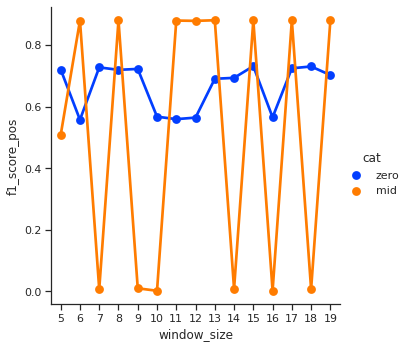

In [50]:
# Window size and its effect on f1score for positive class
rec4 = rec[['dataset','window_size','cat','threshold','f1_score_pos']]
rec4 = rec4[rec4['threshold'] == 4.0]
rec4 = rec4.groupby(['dataset'])

for key, item in rec4:
  tmp = rec4.get_group(key)
  sb.catplot(x='window_size', y='f1_score_pos', hue='cat', data=tmp, kind='point')
  # plt.title(str(key))

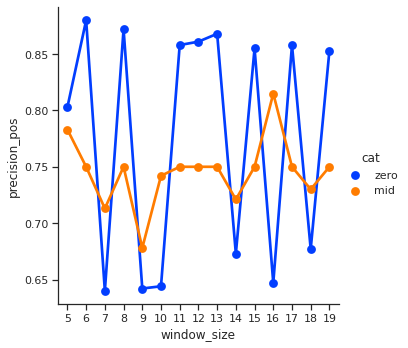

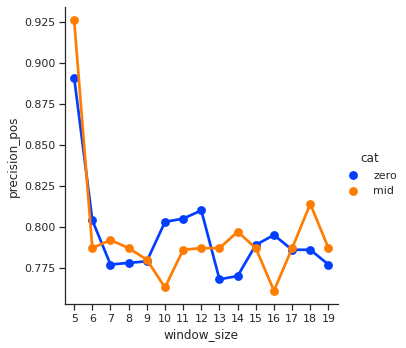

In [51]:
# Window size and its effect on precision for positive class
rec4 = rec[['dataset','window_size','cat','threshold','precision_pos']]
rec4 = rec4[rec4['threshold'] == 4.0]
rec4 = rec4.groupby(['dataset'])

for key, item in rec4:
  tmp = rec4.get_group(key)
  sb.catplot(x='window_size', y='precision_pos', hue='cat', data=tmp, kind='point')
  # plt.title(str(key))

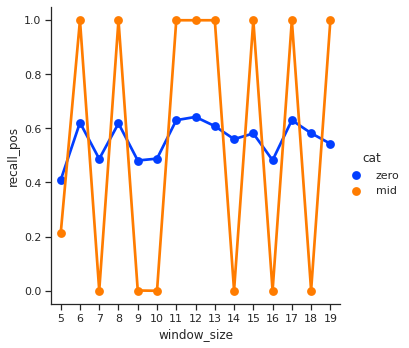

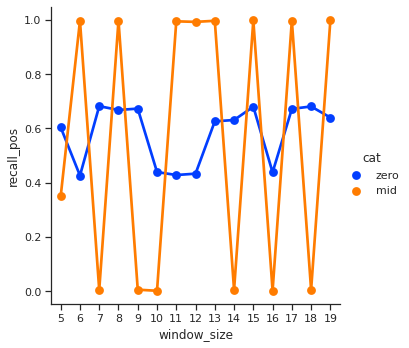

In [52]:
# Window size and its effect on recall for positive class
rec4 = rec[['dataset','window_size','cat','threshold','recall_pos']]
rec4 = rec4[rec4['threshold'] == 4.0]
rec4 = rec4.groupby(['dataset'])

for key, item in rec4:
  tmp = rec4.get_group(key)
  sb.catplot(x='window_size', y='recall_pos', hue='cat', data=tmp, kind='point')
  # plt.title(str(key))

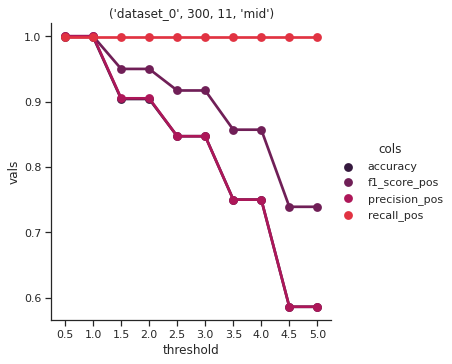

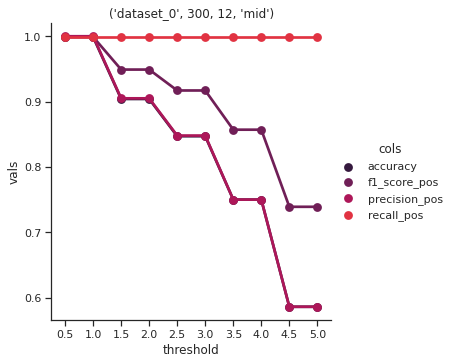

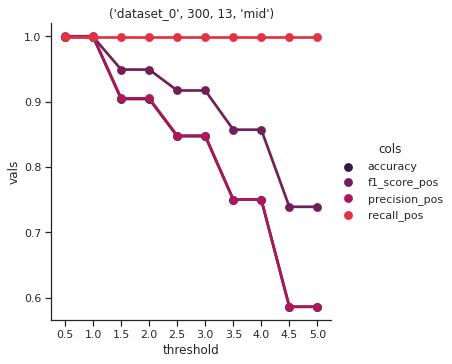

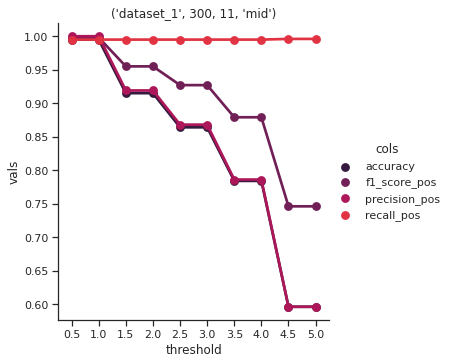

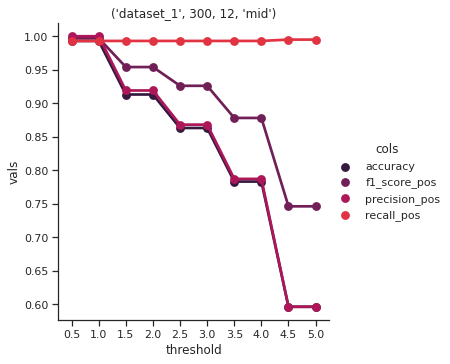

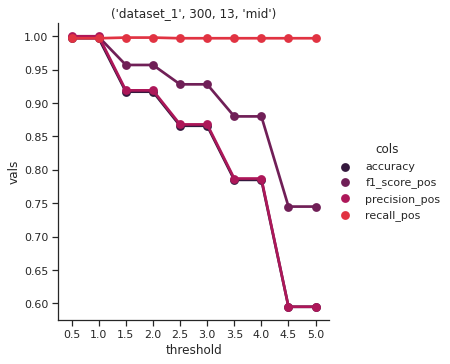

In [53]:
# Based on the best window-size from the above plots and determining that mid point showed better results than zeroed one

warnings.filterwarnings("ignore")
sb.set_theme(style="ticks", palette="rocket")

rec2 = rec.loc[rec['window_size'].isin([11, 12, 13])]
rec2 = rec2.loc[rec['cat'].isin(['mid'])]
rec2 = rec2.groupby(['dataset','neurons','window_size','cat'])


for key, item in rec2:
  tmp = rec2.get_group(key)
  tmp.drop(['dataset','neurons','window_size','cat','f1_score_neg','precision_neg','recall_neg'],axis = 1, inplace=True)
  dfm = tmp.melt('threshold', var_name='cols', value_name='vals')
  sb.catplot(x='threshold', y="vals", hue='cols', data=dfm, kind='point')
  plt.title(str(key))




## Visualization

In [54]:
def top_used(text):
  global words 
  for t in text:
    words[t] += 1

word_counts = []
for i in range(len(df)):
  words = defaultdict(int)
  df[i].tokenized.apply(top_used)
  word_counts.append(words)

count_dfs = []
for i in range(len(df)): 
  key = list(word_counts[i].keys())
  value = list(word_counts[i].values())
  count_df = pd.DataFrame(list(zip(key, value)), columns=['word', 'count'])
  count_dfs.append(count_df)

cnt_class = []
for i in range(len(df)):
  tmp = count_dfs[i].merge(class_fixed[i], on='word', how='left').sort_values(by = ['class','count'],ascending = False).groupby('class').head(10)
  tmp = tmp.loc[tmp['class'].isin(['Positive','Negative'])]
  cnt_class.append(tmp)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

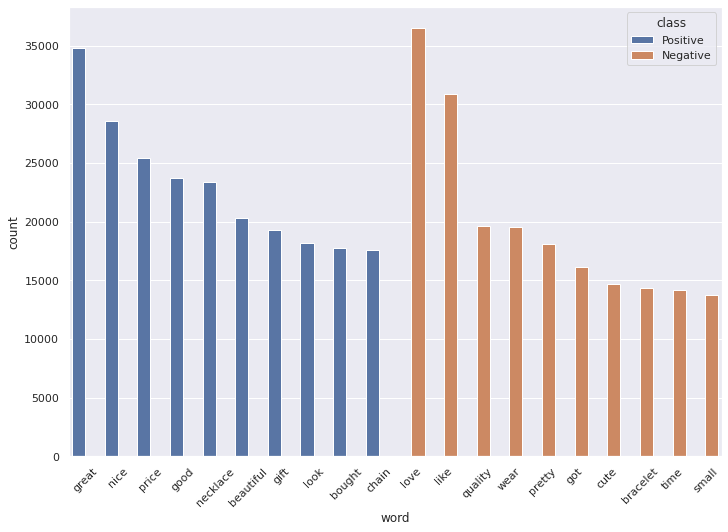

In [55]:
sb.set_theme(style="whitegrid")
sb.set(rc={'figure.figsize':(11.7,8.27)})
ax = sb.barplot(data=cnt_class[0], x='word', y='count', hue='class')
plt.xticks(rotation=45)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

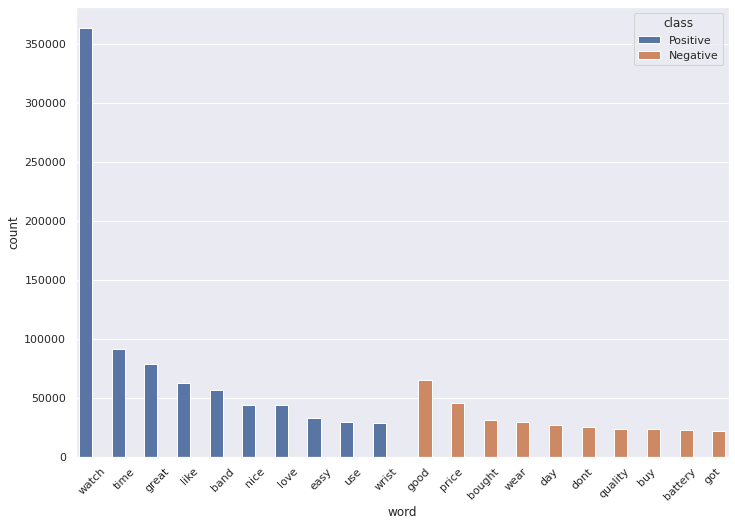

In [56]:
ax = sb.barplot(data=cnt_class[1], x='word', y='count', hue='class')
plt.xticks(rotation=45)